In [1]:
import os
import os.path as p
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import keras
from keras import ops, layers, datasets, Sequential, Model

import torch
import torchvision
from torchvision.transforms import v2
from torchvision.utils import make_grid

# Згарзука и подготовка датасета

torch.Size([70000, 64, 64, 1])


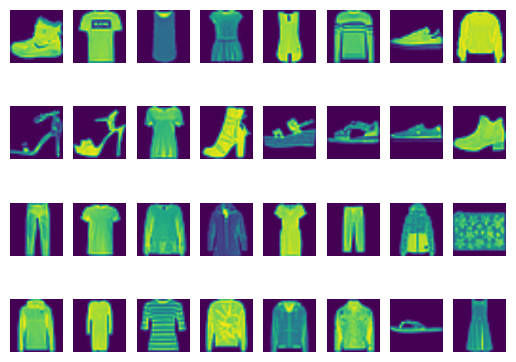

In [82]:
LATENT_DIM = 2
BATCH_SIZE = 32
IMG_SIZE = 64

(X_train, _), (X_test, _) = datasets.fashion_mnist.load_data()
dataset = v2.Resize(size=IMG_SIZE)(
    torch.from_numpy(np.concatenate((X_train, X_test), axis=0) / 255.)
)
dataset = torch.unsqueeze(dataset, -1)
print(dataset.size())

imgs = dataset[:BATCH_SIZE, :, :, :].squeeze()
fig, axes = plt.subplots(nrows=4, ncols=8)
for ax, img in zip(axes.flat, imgs):
    ax.imshow(img)
    ax.axis("off")
plt.show()
dataset = dataset.numpy()

# Эдкодер

In [83]:
encoder_input = keras.Input(shape=(64, 64, 1))
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_input)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(x)

z_mean = layers.Dense(LATENT_DIM, name="z_mean")(x)
z_log_var = layers.Dense(LATENT_DIM, name="z_log_var")(x)

encoder = Model(encoder_input, [z_mean, z_log_var], name="encoder")

In [84]:
encoder.summary()

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 64, 64, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 32, 32,    │        320 │ input_layer_4[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 16, 16,    │     18,496 │ conv2d_6[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_2 (Flatten) │ (None, 16384)     │          0 │ conv2d_7[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 16)        │    262,160 │ flatten_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (Dense)      │ (None, 2)         │         34 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_log_var (Dense)   │ (None, 2)         │         34 │ dense_4[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 281,044 (1.07 MB)

 Trainable params: 281,044 (1.07 MB)

 Non-trainable params: 0 (0.00 B)

# Декодер

In [85]:
class Sampler(layers.Layer):
    """
    используется, чтобы декодер имел возможность выбрать точку
    из латентного пространства
    """
    def call(self, z_mean, z_log_var):
        batch_size = int(tf.shape(z_mean)[0])
        epsilon = tf.random.normal(shape=(batch_size, LATENT_DIM))
        return z_mean + tf.exp(.5 * z_log_var) * epsilon

decoder_input = keras.Input(shape=(LATENT_DIM,))
x = layers.Dense(8 * 8 * 64, activation="relu")(decoder_input)
x = layers.Reshape((8, 8, 64))(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(16, 3, activation="relu", strides=2, padding="same")(x)
decoder_output = layers.Conv2D(1, 3, activation="sigmoid", padding="same")(x)
decoder = Model(decoder_input, decoder_output, name="decoder")

In [86]:
decoder.summary()

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 4096)           │        12,288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_2 (Reshape)             │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_6              │ (None, 16, 16, 64)     │        36,928 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_7              │ (None, 32, 32, 32)     │        18,464 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_8              │ (None, 64, 64, 16)     │         4,624 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 64, 64, 1)      │           145 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 72,449 (283.00 KB)

 Trainable params: 72,449 (283.00 KB)

 Non-trainable params: 0 (0.00 B)

# VAE

In [87]:
class VAE(Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.sampler = Sampler()
        self.total_loss_tracker = keras.metrics.Mean(
            name="total_loss"
        )
        self.reconstruction_loss_tracker = \
            keras.metrics.Mean(
                name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(
            name="kl_loss"
        )

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var = \
                self.encoder(data)
            z = self.sampler(z_mean, z_log_var)
            reconstruction = self.decoder(z)
            reconstruction_loss = keras.ops.squeeze(
                keras.losses.binary_crossentropy(
                    data, reconstruction, axis=(1, 2)
                )
            )
            kl_loss = tf.math.reduce_sum(
                -.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)),
                axis=-1
            )
            total_loss = reconstruction_loss + kl_loss
            grads = tape.gradient(total_loss, self.trainable_weights)
            self.optimizer.apply_gradients(
                zip(
                    grads, self.trainable_weights
                )
            )
            self.total_loss_tracker.update_state(total_loss)
            self.reconstruction_loss_tracker.update_state(reconstruction_loss)
            self.kl_loss_tracker.update_state(kl_loss)
            return {
                "total_loss": self.total_loss_tracker.result(),
                "reconstruction_loss": self.reconstruction_loss_tracker.result(),
                "kl_loss": self.kl_loss_tracker.result(),
            }


# Обучение модели

In [88]:
vae = VAE(encoder, decoder)
vae.compile(
    optimizer=keras.optimizers.Adam(),
    run_eagerly=True,
)
vae.fit(dataset, epochs=30, batch_size=BATCH_SIZE)

Epoch 1/30
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 498s 227ms/step - kl_loss: 2.5787e-04 - reconstruction_loss: 0.5120 - total_loss: 0.5122
Epoch 2/30
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 510s 233ms/step - kl_loss: 2.1796e-07 - reconstruction_loss: 0.4936 - total_loss: 0.4936
Epoch 3/30
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 486s 222ms/step - kl_loss: 4.9153e-07 - reconstruction_loss: 0.4941 - total_loss: 0.4941
Epoch 4/30
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 429s 196ms/step - kl_loss: 3.7136e-07 - reconstruction_loss: 0.4941 - total_loss: 0.4941
Epoch 5/30
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 438s 200ms/step - kl_loss: 2.5501e-07 - reconstruction_loss: 0.4936 - total_loss: 0.4936
Epoch 6/30
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 432s 197ms/step - kl_loss: 2.8492e-07 - reconstruction_loss: 0.4933 - total_loss: 0.4933
Epoch 7/30
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 432s 197ms/step - kl_loss: 2.9541e-07 - reconstruction_loss: 0.4935 - total_loss: 0.4935
Epoch 8/30
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 436s 199ms/step - kl_loss: 1.7887e-07 - r

In [91]:
if not p.exists("./weights"):
    os.mkdir("./weights")
    # для теста :)
    vae.decoder.save("./weights/vae_decoder.keras")
    decoder.save("./weights/decoder.keras")
else:
    _decoder = keras.models.load_model("./weights/vae_decoder.keras")
    decoder = keras.models.load_model("./weights/decoder.keras")
    

# Визуализация результатов

In [89]:
n = 30
X = np.linspace(-1, 1, n)
Y = np.linspace(-1, 1, n)[::-1]

fig = np.zeros(shape=(IMG_SIZE * n, IMG_SIZE * n))
for row in range(n):
    for col in range(n):
        point = np.array([[X[col], Y[row]]])
        pred = vae.decoder.predict(point, verbose=0).squeeze()
        fig[
            row * IMG_SIZE : (row + 1) * IMG_SIZE,
            col * IMG_SIZE : (col + 1) * IMG_SIZE
        ] = pred


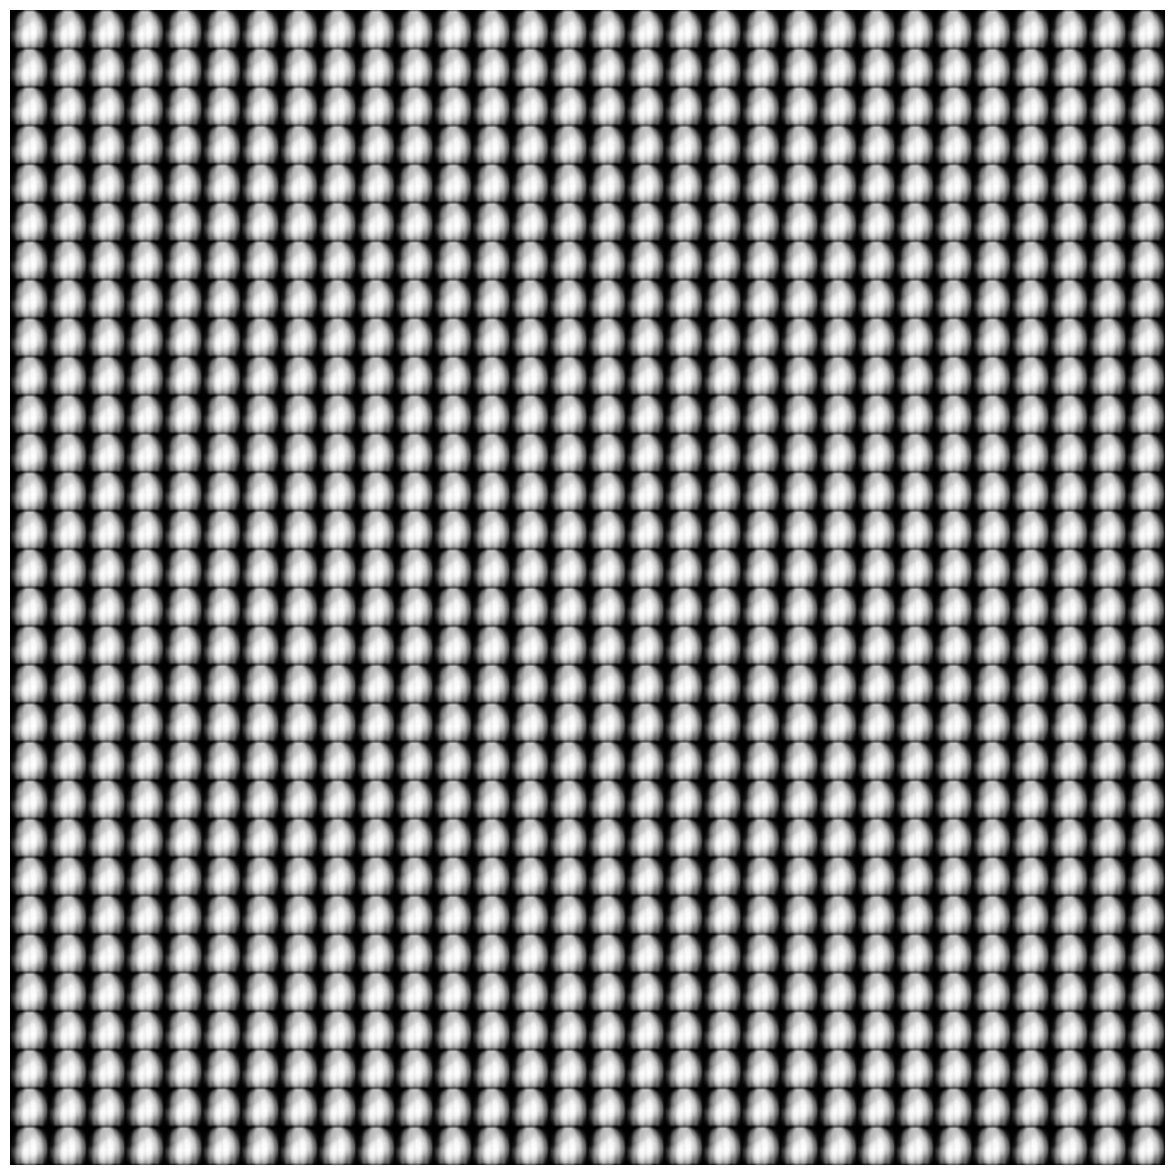

In [90]:
plt.figure(figsize=(15, 15))
plt.xlabel("z[0]")
plt.ylabel("z[1]")
plt.axis("off")
plt.imshow(fig, cmap="Greys_r")